In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
%matplotlib inline
import random
from scipy.stats import entropy
from numpy.linalg import norm

### Create corpus from the same author and same-size random sample

In [3]:
df = pd.read_csv('../../data/shakespare_william_works_preprocessed.tsv', sep = '\t')

In [4]:
df['Author'].value_counts().head(1).index.tolist()[0]

'Lady_Loki'

In [5]:
df_Au = df[df.Author == 'Lady_Loki']
df_Rand = df.sample(len(df_Au))

### General functions

In [7]:
def bootstrap_resample(li):
    if len(li) > 0:
        ave_original = np.average(li)
        aves = []
        for i in range(1000):
            sample = []
            for i in range(len(li)):
                sample.append(random.choice(li))
            aves.append(np.average(sample))
        tail = sorted(aves)[24]
        head = sorted(aves)[975]
        return (ave_original, tail, head)

In [8]:
def process_sentence(sentence):
    # input: sentence as a string
    # output: a list of words in the sentence
    sentence = re.sub(r'aA|aa', 'a', sentence)
    sentence = re.sub(r'\\xe2........|\\xc|\\xa|\\n|[0123456789*_]', '', sentence).lower()
    sentence = re.findall(u'(?u)\\b\\w\\w+\\b', sentence)
    return sentence

In [9]:
def plot(results_au, results_rand, label):
    fig = plt.figure()
    lower_error1 = [results_au[0] - results_au[1]]
    upper_error1 = [results_au[2] - results_au[0]]
    lower_error2 = [results_rand[0] - results_rand[1]]
    upper_error2 = [results_rand[2] - results_rand[0]]

    asymmetric_error1 =[lower_error1,lower_error2 ]
    asymmetric_error2 =[upper_error1, upper_error2]
    p1 = [1, 2]
    p2 = [results_au[0], results_rand[0]]

    plt.errorbar(p1, p2, yerr=[asymmetric_error1, asymmetric_error2],fmt='o')
    plt.xlim(0,3)
    plt.legend(loc='lower right')
    plt.xticks(p1, ['Same author', 'Random author'])
    plt.ylabel(label, fontsize = 14)

### tfidf weighting

In [10]:
# create a corpus to give to sklearn
def create_corpus_for_voc(df):
    doc = []
    for i in df.Text.tolist():
        #Remove some non-ascii characters and 'aa's
        i = re.sub(r'aA|aa', 'a', i)
        i = re.sub(r'\\xe2........|\\xc|\\xa|\\n|[0123456789*_]', '', i)
        i = i.lower()
        doc.append(i)  
    return doc

In [11]:
vectorizer = TfidfVectorizer(min_df=1)
corpus = create_corpus_for_voc(df_Au)
au_dist = vectorizer.fit_transform(corpus).todense()

vectorizer = TfidfVectorizer(min_df=1)
corpus = create_corpus_for_voc(df_Rand)
rand_dist = vectorizer.fit_transform(corpus).todense()

### + JS distance

In [12]:
def JSD(P, Q):
    _P = P / norm(P, ord=1)
    _Q = Q / norm(Q, ord=1)
    _M = 0.5 * (_P + _Q)
    return 0.5 * (entropy(_P, _M) + entropy(_Q, _M))

In [13]:
def calc_results(au_dist,rand_dist):
    results_au = []
    results_rand = []
    for i in range(len(au_dist)):
        for j in range(i, len(au_dist)):
            results_au.append(JSD(au_dist[i].tolist()[0], au_dist[j].tolist()[0]))
    results_au = bootstrap_resample(results_au)
    for i in range(len(rand_dist)):
        for j in range(i, len(rand_dist)):
            results_rand.append(JSD(rand_dist[i].tolist()[0], rand_dist[j].tolist()[0]))
    results_rand = bootstrap_resample(results_rand)
    return results_au, results_rand

In [14]:
results_au, results_rand = calc_results(au_dist,rand_dist)

/Users/jingy/anaconda/envs/python35/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


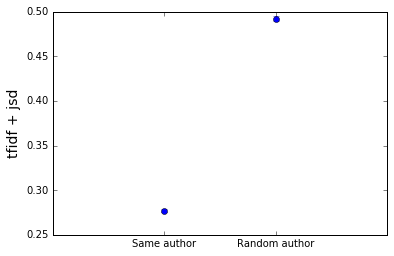

In [15]:
plot(results_au, results_rand, 'tfidf + jsd')